
# LOCOMOTION Activity Recognition using K-fold with LSTM Neural Network

# Reading the dataset

In [1]:
import pandas as pd
import numpy as np
import glob

import tensorflow as tf
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score,confusion_matrix, plot_confusion_matrix
import time
from typing import Any
import torch
import torch.nn as nn

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from pandas import DataFrame
from keras.models import load_model


files = glob.glob('/data/shk/dl-for-har/tutorial_notebooks/Prof_New/*.csv')

name = [file.split('/')[-1] for file in files]
df = pd.concat(map(pd.read_csv,files),ignore_index = True) #4230213 rows × 10 columns

data = df

clean_data = data[data['locomotion']!='not_labeled']
clean_data = clean_data[data['locomotion'].notna()]
clean_data['locomotion'].replace({'layup':'jumping'},inplace=True)
print('Before_game',len(clean_data))

new_data = clean_data[clean_data.coarse != 'game'] #623758 rows × 10 columns
new_data = new_data.drop(columns='coarse')
new_data = new_data.drop(columns='basketball')
new_data = new_data.iloc[:,:6]
print('new_data',new_data.shape)
print('____')

game_data = clean_data[clean_data.coarse == 'game']
game_data = game_data.drop(columns='coarse')
game_data = game_data.drop(columns='basketball')
game_data = game_data.iloc[:,:6] #45446 rows × 6 columns
print('game_data',game_data.shape)

2022-08-15 09:29:14.111404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 09:29:14.111427: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before_game 2710751
new_data (1982320, 6)
____
game_data (728431, 6)


 # Labelling the data

In [2]:
label = new_data['locomotion']
x_axis = sorted(label.unique())
y_axis = label.value_counts()

X = new_data.iloc[:,:-1]#.astype(np.float32)

class_names = ['walking','running','standing','sitting','jumping']
num_classes = len(class_names)

def labelling(clean_data,data_y):
    clean_data[data_y == 'walking'] = 0
    clean_data[data_y == 'running'] = 1
    clean_data[data_y == 'standing'] = 2
    clean_data[data_y == 'sitting'] = 3
    clean_data[data_y == 'jumping'] = 4
    
    return data_y

y = labelling(new_data,new_data.iloc[:,-1]).astype(int)

subject = X['subject']
uni_subject = subject.unique()
uni_subject_count = subject.value_counts()

data_labelled = np.concatenate((X, y[:,None]), axis=1)[:,1:] #669204, 6

/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


# Special preprocessing

In [3]:
data_walking = data_labelled[data_labelled[:,-1] == 0]
data_running = data_labelled[data_labelled[:,-1] == 1]
data_standing = data_labelled[data_labelled[:,-1] == 2]
data_sitting = data_labelled[data_labelled[:,-1] == 3]
data_jumping = data_labelled[data_labelled[:,-1] == 4]


def spilt(data):

    dd = np.asarray(data)
    T = int(0.8* len(dd))
    train_size = int(T)
    test_size = len(dd) - train_size

    train_df,test_df = torch.utils.data.random_split(dd, [train_size,test_size])
    X = train_df[:][:,0:4]
    Y = train_df[:][:,4]

    X_v = test_df[:][:,0:4]
    y_v = test_df[:][:,4]
    
    return X,Y,X_v,y_v

X_walking,Y_walking,X_v_walking,y_v_walking = spilt(data_walking)
X_running,Y_running,X_v_running,y_v_running = spilt(data_running)
X_standing,Y_standing,X_v_standing,y_v_standing = spilt(data_standing)
X_sitting,Y_sitting,X_v_sitting,y_v_sitting = spilt(data_sitting)
X_jumping,Y_jumping,X_v_jumping,y_v_jumping = spilt(data_jumping)


X = np.concatenate((X_walking, X_running,X_standing,X_sitting,X_jumping), axis=0)[:,1:]
Y = np.concatenate((Y_walking, Y_running,Y_standing,Y_sitting,Y_jumping), axis=0)

X_v = np.concatenate((X_v_walking, X_v_running,X_v_standing,X_v_sitting,X_v_jumping), axis=0)[:,1:]
y_v = np.concatenate((y_v_walking, y_v_running,y_v_standing,y_v_sitting,y_v_jumping), axis=0)

train_data = np.column_stack((X,Y))
valid_data = np.column_stack((X_v,y_v))

# Sliding Window

In [4]:
def sliding_window(data, samples_per_window, overlap_ratio):
    windows = []
    indices = []
    curr = 0
    win_len = int(samples_per_window)
    
    if overlap_ratio is not None:
        overlapping_elements = int((overlap_ratio / 100) * (win_len))
        if overlapping_elements >= win_len:
            print('Number of overlapping elements exceeds window size.')
            return
    while curr < len(data) - win_len:
        windows.append(data[curr:curr + win_len])
        indices.append([curr, curr + win_len])
        curr = curr + win_len - overlapping_elements
    try:
        result_windows = np.array(windows)
        result_indices = np.array(indices)
    except:
        result_windows = np.empty(shape=(len(windows), win_len, data.shape[1]), dtype=object)
        result_indices = np.array(indices)
        for i in range(0, len(windows)):
            result_windows[i] = windows[i]
            result_indices[i] = indices[i]
    return result_windows, result_indices

def apply_sliding_window(data_x, data_y, sliding_window_size, sampling_rate, sliding_window_overlap):
    
    output_x, _ = sliding_window(data_x, sliding_window_size, sliding_window_overlap)
    output_y, _ = sliding_window(data_y, sliding_window_size, sliding_window_overlap)

    return output_x,output_y

sw_length = 50
sw_overlap = 25

X_train, y_train = apply_sliding_window(X, Y, sw_length, sampling_rate=50,sliding_window_overlap=sw_overlap)
X_valid, y_valid = apply_sliding_window(X_v, y_v, sw_length, sampling_rate=50,sliding_window_overlap=sw_overlap)

X_train, y_train = X_train.astype(np.float32), y_train.astype(np.uint8)
X_valid, y_valid = X_valid.astype(np.float32), y_valid.astype(np.uint8)

print("\nShape of the X_train and Y_train datasets after windowing: ")
print(X_train.shape, y_train.shape) 

print("\nShape of the X_valid and y_valid datasets after windowing: ")
print(X_valid.shape, y_valid.shape)

y_train = y_train[:,0]
y_valid = y_valid[:,0]

data_X = np.concatenate((X_train,X_valid),axis=0) 

print("\nShape of the X after windowing: ")
print(data_X.shape)

print("\nShape of the Y after windowing: ")
data_Y = np.concatenate((y_train,y_valid),axis=0) 
print(data_Y.shape)


Shape of the X_train and Y_train datasets after windowing: 
(41732, 50, 3) (41732, 50)

Shape of the X_valid and y_valid datasets after windowing: 
(10432, 50, 3) (10432, 50)

Shape of the X after windowing: 
(52164, 50, 3)

Shape of the Y after windowing: 
(52164,)


# Network

In [5]:
def Network(data_X, data_Y, k=10):
    
    fold = 1 
    train_preds = []
    train_gt = []
    test_preds = []
    test_gt = []   
    loss_acc = []
    c_matrix =[]
    perfold_f1_train = []
    perfold_f1_test = []
    sub_plot =[]
    skf = StratifiedKFold(n_splits=k,random_state=None, shuffle=False)

    for train_index, test_index in skf.split(data_X, data_Y):

        print('Current fold: ', fold)
        X_train, X_test = data_X[train_index], data_X[test_index]
        y_train, y_test = data_Y[train_index], data_Y[test_index]

        #Model architecture            
        model = Sequential()
        model.add(LSTM(units=26,input_shape=[X_train.shape[1], X_train.shape[2]], activation = 'relu', return_sequences = True))
        model.add(Dropout(rate=0.1))
        model.add(Flatten())
        model.add(Dense(units=5000, activation='relu'))
        model.add(Dropout(rate=0.2))
        model.add(Dense(units=1500, activation='relu'))
        model.add(Dense(units=800, activation='relu'))
        model.add(Dropout(rate=0.3))
        model.add(Dense(units=5, activation='softmax'))

            #Compile the model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        #Fit data to model
        hs = model.fit(X_train,y_train,epochs=25, validation_data=(X_test,y_test),verbose=1)
        y_pred_train = np.argmax(model.predict(X_train), axis=-1)
        y_pred_test = np.argmax(model.predict(X_test), axis=-1)


        #Training
        acc_train = jaccard_score(y_train, y_pred_train, average='macro')
        pre_train = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
        reca_train = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
        f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

        train_preds = np.concatenate((np.array(train_preds, int), np.array(y_pred_train, int)))
        train_gt = np.concatenate((np.array(train_gt, int), np.array(y_train, int)))

        print("___Training____")
        print(f"accuracy {round(acc_train,3)*100} ,precision {round(pre_train,3)*100}, recall {round(reca_train,3)*100},f1_score {round(f1_train,3)*100} ")

        #Validation
        acc_test = jaccard_score(y_test, y_pred_test, average='macro')
        pre_test = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
        reca_test = recall_score(y_test, y_pred_test, average='macro', zero_division=0)
        f1_test = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

        test_preds = np.concatenate((np.array(test_preds, int), np.array(y_pred_test, int)))
        test_gt = np.concatenate((np.array(test_gt, int), np.array(y_test, int)))

        print("___Validation____")
        print(f"accuracy {round(acc_test,3)*100} ,precision {round(pre_test,3)*100}, recall {round(reca_test,3)*100}, f1_score {round(f1_test,3)*100} ")

        #Graphs
        loss_acc.append(model.evaluate(X_test,y_test))
        c_matrix.append(confusion_matrix(y_test, y_pred_test))
        fold+=1    
        perfold_f1_train.append(f1_train)
        perfold_f1_test.append(f1_test)
        sub_plot.append(hs.history)

        #Save Weights
        model.save_weights('./Pre_Trained_models/locomotion_test_data/locomotion_test_data',overwrite=True)
        model.save('./Pre_Trained_models/locomotion_test_data',overwrite=True)
    
    return train_preds,train_gt,test_preds,test_gt,loss_acc,c_matrix,perfold_f1_train,perfold_f1_test,sub_plot

In [6]:
train_preds,train_gt,test_preds,test_gt,loss_acc,c_matrix,perfold_f1_train,perfold_f1_test,sub_plot = Network(data_X, data_Y)

Current fold:  1


2022-08-15 09:29:55.944118: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-08-15 09:29:55.944149: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DeepCube
2022-08-15 09:29:55.944154: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DeepCube
2022-08-15 09:29:55.944261: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-08-15 09:29:55.944290: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-08-15 09:29:55.944553: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operat

Epoch 1/25
1468/1468 [==============================] - 73s 49ms/step - loss: 0.1850 - accuracy: 0.9318 - val_loss: 0.0718 - val_accuracy: 0.9758
Epoch 2/25
1468/1468 [==============================] - 72s 49ms/step - loss: 0.0805 - accuracy: 0.9729 - val_loss: 0.0944 - val_accuracy: 0.9603
Epoch 3/25
1468/1468 [==============================] - 72s 49ms/step - loss: 0.0551 - accuracy: 0.9819 - val_loss: 0.0337 - val_accuracy: 0.9893
Epoch 4/25
1468/1468 [==============================] - 70s 47ms/step - loss: 0.0465 - accuracy: 0.9843 - val_loss: 0.0241 - val_accuracy: 0.9923
Epoch 5/25
1468/1468 [==============================] - 71s 48ms/step - loss: 0.0427 - accuracy: 0.9858 - val_loss: 0.0210 - val_accuracy: 0.9923
Epoch 6/25
1468/1468 [==============================] - 71s 48ms/step - loss: 0.0363 - accuracy: 0.9879 - val_loss: 0.0471 - val_accuracy: 0.9862
Epoch 7/25
1468/1468 [==============================] - 71s 48ms/step - loss: 0.0321 - accuracy: 0.9896 - val_loss: 0.0226 -

2022-08-15 10:08:02.249310: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./locomotion_test_data/assets


Current fold:  2
Epoch 1/25
1468/1468 [==============================] - 120s 81ms/step - loss: 0.1878 - accuracy: 0.9309 - val_loss: 0.0856 - val_accuracy: 0.9666
Epoch 2/25
1468/1468 [==============================] - 119s 81ms/step - loss: 0.0845 - accuracy: 0.9709 - val_loss: 0.0498 - val_accuracy: 0.9793
Epoch 3/25
1468/1468 [==============================] - 119s 81ms/step - loss: 0.0584 - accuracy: 0.9805 - val_loss: 0.0515 - val_accuracy: 0.9847
Epoch 4/25
1468/1468 [==============================] - 118s 81ms/step - loss: 0.0500 - accuracy: 0.9831 - val_loss: 0.0538 - val_accuracy: 0.9812
Epoch 5/25
1468/1468 [==============================] - 119s 81ms/step - loss: 0.0459 - accuracy: 0.9860 - val_loss: 0.0583 - val_accuracy: 0.9812
Epoch 6/25
1468/1468 [==============================] - 117s 80ms/step - loss: 0.0381 - accuracy: 0.9876 - val_loss: 0.0757 - val_accuracy: 0.9751
Epoch 7/25
1468/1468 [==============================] - 118s 81ms/step - loss: 0.0386 - accuracy: 0.9

INFO:tensorflow:Assets written to: ./locomotion_test_data/assets


Current fold:  3
Epoch 1/25
1468/1468 [==============================] - 111s 74ms/step - loss: 0.1790 - accuracy: 0.9335 - val_loss: 0.2877 - val_accuracy: 0.9103
Epoch 2/25
1468/1468 [==============================] - 108s 74ms/step - loss: 0.0792 - accuracy: 0.9720 - val_loss: 0.1592 - val_accuracy: 0.9509
Epoch 3/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0626 - accuracy: 0.9788 - val_loss: 0.0439 - val_accuracy: 0.9849
Epoch 4/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0516 - accuracy: 0.9823 - val_loss: 0.0480 - val_accuracy: 0.9833
Epoch 5/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0430 - accuracy: 0.9866 - val_loss: 0.0292 - val_accuracy: 0.9898
Epoch 6/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0368 - accuracy: 0.9883 - val_loss: 0.0571 - val_accuracy: 0.9816
Epoch 7/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0365 - accuracy: 0.9

INFO:tensorflow:Assets written to: ./locomotion_test_data/assets


Current fold:  4
Epoch 1/25
1468/1468 [==============================] - 85s 57ms/step - loss: 0.1960 - accuracy: 0.9282 - val_loss: 0.0636 - val_accuracy: 0.9772
Epoch 2/25
1468/1468 [==============================] - 102s 69ms/step - loss: 0.0811 - accuracy: 0.9716 - val_loss: 0.0448 - val_accuracy: 0.9837
Epoch 3/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0599 - accuracy: 0.9799 - val_loss: 0.0292 - val_accuracy: 0.9896
Epoch 4/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0445 - accuracy: 0.9853 - val_loss: 0.0231 - val_accuracy: 0.9925
Epoch 5/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0413 - accuracy: 0.9868 - val_loss: 0.0298 - val_accuracy: 0.9893
Epoch 6/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0348 - accuracy: 0.9879 - val_loss: 0.0218 - val_accuracy: 0.9935
Epoch 7/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0354 - accuracy: 0.98

INFO:tensorflow:Assets written to: ./locomotion_test_data/assets


Current fold:  5
Epoch 1/25
1468/1468 [==============================] - 109s 73ms/step - loss: 0.1708 - accuracy: 0.9382 - val_loss: 0.0703 - val_accuracy: 0.9743
Epoch 2/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0739 - accuracy: 0.9745 - val_loss: 0.0499 - val_accuracy: 0.9835
Epoch 3/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0567 - accuracy: 0.9809 - val_loss: 0.0291 - val_accuracy: 0.9895
Epoch 4/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0466 - accuracy: 0.9843 - val_loss: 0.0320 - val_accuracy: 0.9896
Epoch 5/25
1468/1468 [==============================] - 108s 74ms/step - loss: 0.0405 - accuracy: 0.9864 - val_loss: 0.0248 - val_accuracy: 0.9916
Epoch 6/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0334 - accuracy: 0.9887 - val_loss: 0.0440 - val_accuracy: 0.9889
Epoch 7/25
1468/1468 [==============================] - 86s 59ms/step - loss: 0.0356 - accuracy: 0.98

INFO:tensorflow:Assets written to: ./locomotion_test_data/assets


Current fold:  6
Epoch 1/25
1468/1468 [==============================] - 111s 74ms/step - loss: 0.1829 - accuracy: 0.9335 - val_loss: 0.0891 - val_accuracy: 0.9664
Epoch 2/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0804 - accuracy: 0.9723 - val_loss: 0.0788 - val_accuracy: 0.9705
Epoch 3/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0606 - accuracy: 0.9800 - val_loss: 0.1347 - val_accuracy: 0.9548
Epoch 4/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0462 - accuracy: 0.9841 - val_loss: 0.0377 - val_accuracy: 0.9827
Epoch 5/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0388 - accuracy: 0.9872 - val_loss: 0.0325 - val_accuracy: 0.9891
Epoch 6/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0378 - accuracy: 0.9873 - val_loss: 0.0258 - val_accuracy: 0.9923
Epoch 7/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0353 - accuracy: 0.9

INFO:tensorflow:Assets written to: ./locomotion_test_data/assets


Current fold:  7
Epoch 1/25
1468/1468 [==============================] - 110s 74ms/step - loss: 0.1693 - accuracy: 0.9382 - val_loss: 0.0878 - val_accuracy: 0.9676
Epoch 2/25
1468/1468 [==============================] - 108s 74ms/step - loss: 0.0754 - accuracy: 0.9738 - val_loss: 0.0732 - val_accuracy: 0.9774
Epoch 3/25
1468/1468 [==============================] - 108s 74ms/step - loss: 0.0531 - accuracy: 0.9828 - val_loss: 0.0336 - val_accuracy: 0.9864
Epoch 4/25
1468/1468 [==============================] - 108s 74ms/step - loss: 0.0442 - accuracy: 0.9860 - val_loss: 0.0313 - val_accuracy: 0.9895
Epoch 5/25
1468/1468 [==============================] - 109s 74ms/step - loss: 0.0406 - accuracy: 0.9862 - val_loss: 0.0252 - val_accuracy: 0.9902
Epoch 6/25
1468/1468 [==============================] - 108s 74ms/step - loss: 0.0394 - accuracy: 0.9881 - val_loss: 0.0184 - val_accuracy: 0.9941
Epoch 7/25
1468/1468 [==============================] - 108s 74ms/step - loss: 0.0335 - accuracy: 0.9

INFO:tensorflow:Assets written to: ./locomotion_test_data/assets


Current fold:  8
Epoch 1/25
1468/1468 [==============================] - 110s 74ms/step - loss: 0.1934 - accuracy: 0.9288 - val_loss: 0.0700 - val_accuracy: 0.9757
Epoch 2/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0786 - accuracy: 0.9721 - val_loss: 0.0553 - val_accuracy: 0.9820
Epoch 3/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0593 - accuracy: 0.9793 - val_loss: 0.0357 - val_accuracy: 0.9889
Epoch 4/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0509 - accuracy: 0.9828 - val_loss: 0.0366 - val_accuracy: 0.9919
Epoch 5/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0447 - accuracy: 0.9860 - val_loss: 0.0297 - val_accuracy: 0.9910
Epoch 6/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0415 - accuracy: 0.9862 - val_loss: 0.0323 - val_accuracy: 0.9931
Epoch 7/25
1468/1468 [==============================] - 108s 74ms/step - loss: 0.0303 - accuracy: 0.9

INFO:tensorflow:Assets written to: ./locomotion_test_data/assets


Current fold:  9
Epoch 1/25
1468/1468 [==============================] - 110s 73ms/step - loss: 0.1757 - accuracy: 0.9365 - val_loss: 0.1158 - val_accuracy: 0.9592
Epoch 2/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0722 - accuracy: 0.9761 - val_loss: 0.0501 - val_accuracy: 0.9827
Epoch 3/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0572 - accuracy: 0.9804 - val_loss: 0.0492 - val_accuracy: 0.9852
Epoch 4/25
1468/1468 [==============================] - 108s 73ms/step - loss: 0.0459 - accuracy: 0.9845 - val_loss: 0.0380 - val_accuracy: 0.9872
Epoch 5/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0394 - accuracy: 0.9872 - val_loss: 0.0434 - val_accuracy: 0.9831
Epoch 6/25
1468/1468 [==============================] - 108s 74ms/step - loss: 0.0353 - accuracy: 0.9882 - val_loss: 0.0336 - val_accuracy: 0.9877
Epoch 7/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0314 - accuracy: 0.9

INFO:tensorflow:Assets written to: ./locomotion_test_data/assets


Current fold:  10
Epoch 1/25
1468/1468 [==============================] - 110s 74ms/step - loss: 0.1728 - accuracy: 0.9381 - val_loss: 0.1109 - val_accuracy: 0.9615
Epoch 2/25
1468/1468 [==============================] - 99s 68ms/step - loss: 0.0923 - accuracy: 0.9680 - val_loss: 0.0612 - val_accuracy: 0.9806
Epoch 3/25
1468/1468 [==============================] - 95s 65ms/step - loss: 0.0659 - accuracy: 0.9775 - val_loss: 0.1653 - val_accuracy: 0.9475
Epoch 4/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0589 - accuracy: 0.9806 - val_loss: 0.0370 - val_accuracy: 0.9906
Epoch 5/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0396 - accuracy: 0.9864 - val_loss: 0.0337 - val_accuracy: 0.9931
Epoch 6/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0382 - accuracy: 0.9867 - val_loss: 0.0449 - val_accuracy: 0.9852
Epoch 7/25
1468/1468 [==============================] - 107s 73ms/step - loss: 0.0422 - accuracy: 0.98

INFO:tensorflow:Assets written to: ./locomotion_test_data/assets


# Graph per fold

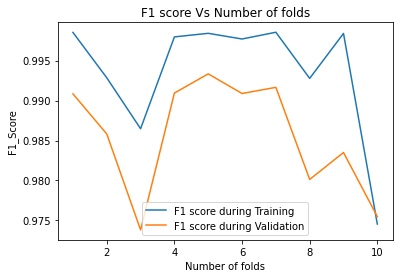

In [7]:
import matplotlib.pyplot as plt
k = 10
x_axis = [i+1 for i in range(k)]

plt.plot(x_axis, perfold_f1_train, label = "F1 score during Training")
plt.plot(x_axis, perfold_f1_test, label = "F1 score during Validation")
 
plt.xlabel('Number of folds')
plt.ylabel('F1_Score')
plt.title('F1 score Vs Number of folds')  
plt.legend()
plt.show()

# Predictions

In [8]:
cls = np.array(range(5))
class_names = ['walking','running','standing','sitting','jumping']

print('\nTraining RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(train_gt, train_preds, average='macro')))
print("Avg. Precision: {0}".format(precision_score(train_gt, train_preds, average='macro')))
print("Avg. Recall: {0}".format(recall_score(train_gt, train_preds, average='macro')))
print("Avg. F1: {0}".format(f1_score(train_gt, train_preds, average='macro')))

print("\nTraining RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nPrecision:")
for i, rslt in enumerate(precision_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nRecall:")
for i, rslt in enumerate(recall_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nF1:")
for i, rslt in enumerate(f1_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))


Training RESULTS: 

Avg. Accuracy: 0.9870149696999926
Avg. Precision: 0.9909654840255702
Avg. Recall: 0.9959209655144804
Avg. F1: 0.9934203561947612

Training RESULTS (PER CLASS): 

Accuracy:
   walking: 99.47117762105665 %
   running: 99.7462112021195 %
   standing: 97.67483243371493 %
   sitting: 99.99382411067194 %
   jumping: 96.62143948243327 %

Precision:
   walking: 99.8385762514812 %
   running: 99.94546111640437 %
   standing: 98.35742444152432 %
   sitting: 99.99382411067194 %
   jumping: 97.34745609270324 %

Recall:
   walking: 99.6314145470772 %
   running: 99.80053278742307 %
   standing: 99.294500723589 %
   sitting: 100.0 %
   jumping: 99.23403469915098 %

F1:
   walking: 99.73488782427106 %
   running: 99.87294437458758 %
   standing: 98.82374122306908 %
   sitting: 99.996911959979 %
   jumping: 98.28169271547391 %


# Validation Accuracies

In [9]:
print('\nValidation RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(test_gt, test_preds, average='macro')))
print("Avg. Precision: {0}".format(precision_score(test_gt, test_preds, average='macro')))
print("Avg. Recall: {0}".format(recall_score(test_gt, test_preds, average='macro')))
print("Avg. F1: {0}".format(f1_score(test_gt, test_preds, average='macro')))

print("\nVALIDATION RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nPrecision:")
for i, rslt in enumerate(precision_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nRecall:")
for i, rslt in enumerate(recall_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nF1:")
for i, rslt in enumerate(f1_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))


Validation RESULTS: 

Avg. Accuracy: 0.9719409939666075
Avg. Precision: 0.9847988150441809
Avg. Recall: 0.9863037697779683
Avg. F1: 0.9855490473618961

VALIDATION RESULTS (PER CLASS): 

Accuracy:
walking: 99.0
running: 99.0
standing: 95.0
sitting: 100.0
jumping: 92.0

Precision:
walking: 100.0
running: 100.0
standing: 97.0
sitting: 100.0
jumping: 96.0

Recall:
walking: 99.0
running: 100.0
standing: 98.0
sitting: 100.0
jumping: 96.0

F1:
walking: 99.0
running: 100.0
standing: 98.0
sitting: 100.0
jumping: 96.0


In [10]:
print("\nGENERALIZATION GAP ANALYSIS: ")
print("\nTrain-Val-Accuracy Difference: {0}".format(jaccard_score(train_gt, train_preds, average='macro') -
                                                  jaccard_score(test_gt, test_preds, average='macro')))
print("Train-Val-Precision Difference: {0}".format(precision_score(train_gt, train_preds, average='macro') -
                                                   precision_score(test_gt, test_preds, average='macro')))
print("Train-Val-Recall Difference: {0}".format(recall_score(train_gt, train_preds, average='macro') -
                                                recall_score(test_gt, test_preds, average='macro')))
print("Train-Val-F1 Difference: {0}".format(f1_score(train_gt, train_preds, average='macro') -
                                            f1_score(test_gt, test_preds, average='macro')))


GENERALIZATION GAP ANALYSIS: 

Train-Val-Accuracy Difference: 0.015073975733385092
Train-Val-Precision Difference: 0.006166668981389289
Train-Val-Recall Difference: 0.009617195736512096
Train-Val-F1 Difference: 0.007871308832865131


# Testing on Game

In [11]:
print('game_data',game_data.shape)

label_game = game_data['locomotion']
x_axis_game = sorted(label_game.unique())
y_axis_game = label_game.value_counts()

X_game = game_data.iloc[:,:-1]


def adjust_lables(clean_data,data_y):
    clean_data[data_y == 'walking'] = 0
    clean_data[data_y == 'running'] = 1
    clean_data[data_y == 'standing'] = 2
    clean_data[data_y == 'sitting'] = 3
    clean_data[data_y == 'jumping'] = 4
    
    return data_y

y_game = adjust_lables(game_data,game_data.iloc[:,-1]).astype(int)

data_labelled_game = np.concatenate((X_game, y_game[:,None]), axis=1)[:,2:] 
print('data_labelled_game ',data_labelled_game.shape)

data_labelled_X = data_labelled_game[:,:-1]
data_labelled_Y = data_labelled_game[:,-1]

print(data_labelled_X.shape,data_labelled_Y.shape)

X_train_game, y_train_game = apply_sliding_window(data_labelled_X, data_labelled_Y, sliding_window_size=sw_length, 
                                        sampling_rate=50,sliding_window_overlap=sw_overlap)


X_train_game, y_train_game = X_train_game.astype(np.float32), y_train_game[:,0].astype(np.uint8)

print("\nShape of the X_train_game and y_train_game datasets after splitting and windowing: ")
print(X_train_game.shape, y_train_game.shape) 

game_data (728431, 6)


/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


data_labelled_game  (728431, 4)
(728431, 3) (728431,)

Shape of the X_train_game and y_train_game datasets after splitting and windowing: 
(19168, 50, 3) (19168,)


# Loading the pretrained model

In [12]:
model = load_model('./Pre_Trained_models/locomotion_test_data')

pt = './Pre_Trained_models/locomotion_test_data/locomotion_test_data'
model.load_weights(pt)

In [13]:
X_tt = data_X
y_tt = data_Y
loss_drill,acc_drill = model.evaluate(X_tt,y_tt)

print('___DRILL___')
print(f'DRILL_loss {round(loss_drill,3)}, Drill_accuracy {round(acc_drill,3)*100}')

loss_game,acc_game = model.evaluate(X_train_game,y_train_game)

print('___GAME___')
print(f'GAME_loss {round(loss_game,3)}, GAME_accuracy {round(acc_game,3)*100}')

1631/1631 [==============================] - 13s 8ms/step - loss: 14.8421 - accuracy: 0.3225
___DRILL___
DRILL_loss 14.842, Drill_accuracy 32.300000000000004
599/599 [==============================] - 6s 9ms/step - loss: 45.6222 - accuracy: 0.1804
___GAME___
GAME_loss 45.622, GAME_accuracy 18.0


In [14]:
y_pred_game = np.argmax(model.predict(X_train_game), axis=-1)

#Training
acc_game = jaccard_score(y_train_game, y_pred_game, average='macro')
pre_game = precision_score(y_train_game, y_pred_game, average='macro', zero_division=0)
reca_game = recall_score(y_train_game, y_pred_game, average='macro', zero_division=0)
f1_game = f1_score(y_train_game, y_pred_game, average='macro', zero_division=0)

print("___GAME____")
print(f"accuracy {round(acc_game,3)*100} ,precision {round(pre_game,3)*100}, recall {round(reca_game,3)*100},f1_score {round(f1_game,3)*100} ")

___GAME____
accuracy 6.4 ,precision 16.6, recall 11.4,f1_score 11.1 


In [15]:
print('\nGame RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(y_train_game, y_pred_game, average='macro')))
print("Avg. Precision: {0}".format(precision_score(y_train_game, y_pred_game, average='macro')))
print("Avg. Recall: {0}".format(recall_score(y_train_game, y_pred_game, average='macro')))
print("Avg. F1: {0}".format(f1_score(y_train_game, y_pred_game, average='macro')))

print("\nGAME RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nPrecision:")
for i, rslt in enumerate(precision_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nRecall:")
for i, rslt in enumerate(recall_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nF1:")
for i, rslt in enumerate(f1_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))


Game RESULTS: 

Avg. Accuracy: 0.06435357185946479
Avg. Precision: 0.16622884742204005
Avg. Recall: 0.1144548717156787
Avg. F1: 0.11074844213422771

GAME RESULTS (PER CLASS): 

Accuracy:
walking: 22.0
running: 8.0
standing: 2.0
sitting: 0.0
jumping: 0.0

Precision:
walking: 64.0
running: 15.0
standing: 3.0
sitting: 0.0
jumping: 0.0

Recall:
walking: 24.0
running: 15.0
standing: 5.0
sitting: 0.0
jumping: 12.0

F1:
walking: 35.0
running: 15.0
standing: 4.0
sitting: 0.0
jumping: 1.0


# END